<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/eeg_mac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of anesthetic concentration from EEG
In this example, we will build a model to predict anesthetic concentration (age-related MAC) from EEG during Sevoflurane anesthesia.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below.
</b> If you do not agree, please close this window.
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Required libraries

In [20]:
!pip install vitaldb

import vitaldb
import numpy as np
import pandas as pd
import os
import scipy.signal
import matplotlib.pyplot as plt
import random
import itertools as it
import numpy as np
from matplotlib import pyplot as plt

## Preprocessing

Load data using <code>VitalDB Web API</code>

In [31]:
SRATE = 128  # in hz
SEGLEN = 4 * SRATE  # segment samples
BATCH_SIZE = 1024
MAX_CASES = 50

df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track information
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # patient information

# track names and column order when loading data
track_names = ['BIS/EEG1_WAV', 'Primus/EXP_SEVO', 'BIS/BIS']
EEG = 0
SEVO = 1
BIS = 2

# Inclusion & Exclusion criteria
caseids = set(df_cases.loc[df_cases['age'] > 18, 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_SEVO', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_DES', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_CE', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN50_CE', 'caseid'])
caseids = list(caseids)
print(f'Total {len(caseids)} cases found')
random.shuffle(caseids)

x = []  # eeg
y = []  # sevo
b = []  # bis
c = []  # caseids
icase = 0  # number of loaded cases
for caseid in caseids:
    print(f'loading {caseid} ({icase + 1}/{MAX_CASES})', end='...', flush=True)

    # Extract data
    vals = vitaldb.load_case(caseid, track_names, 1 / SRATE)
    if np.nanmax(vals[:, SEVO]) < 1:
        print('all sevo <= 1')
        continue

    # Convert etsevo to the age related mac
    age = df_cases.loc[df_cases['caseid'] == caseid, 'age'].values[0]
    vals[:, SEVO] /= 1.80 * 10 ** (-0.00269 * (age - 40))

    if not np.any(vals[:, BIS] > 0):
        print('all bis <= 0')
        continue

    # trim case
    valid_idx = np.where(vals[:, SEVO] > 0)[0]
    first_idx = valid_idx[0]
    last_idx = valid_idx[-1]
    vals = vals[first_idx:last_idx + 1, :]
    if len(vals) < 1800 * SRATE:  # Do not use cases that are shorter than 30 minutes
        print('{} len < 30 min'.format(caseid))
        continue

    # Forward fill in MAC value and BIS value up to 7 seconds
    vals[:, SEVO:] = pd.DataFrame(vals[:, SEVO:]).ffill(limit=7 * SRATE).values

    # Extract data every 2-second from its start to its end and then put into the dataset
    oldlen = len(y)
    for irow in range(SEGLEN, len(vals), SRATE * 2):
        bis = vals[irow, BIS]
        mac = vals[irow, SEVO]
        if np.isnan(bis) or np.isnan(mac) or bis == 0:
            continue
        # add to dataset
        eeg = vals[irow - SEGLEN:irow, EEG]
        x.append(eeg)
        y.append(mac)
        b.append(bis)
        c.append(caseid)

    # print
    icase += 1
    print('{} samples read -> total {} samples ({}/{})'.format(len(y) - oldlen, len(y), icase, MAX_CASES))
    if icase >= MAX_CASES:
        break

# Change the input dataset to a numpy array
x = np.array(x)
y = np.array(y)
b = np.array(b)
c = np.array(c)

loading 2 (1/30)...6790 samples read -> total 6790 samples (1/30)
loading 4 (2/30)...9628 samples read -> total 16418 samples (2/30)
loading 10 (3/30)...9986 samples read -> total 26404 samples (3/30)
loading 12 (4/30)...14640 samples read -> total 41044 samples (4/30)
loading 18 (5/30)...all bis <= 0
loading 21 (5/30)...5627 samples read -> total 46671 samples (5/30)
loading 24 (6/30)...2477 samples read -> total 49148 samples (6/30)
loading 25 (7/30)...6641 samples read -> total 55789 samples (7/30)
loading 27 (8/30)...7960 samples read -> total 63749 samples (8/30)
loading 33 (9/30)...1927 samples read -> total 65676 samples (9/30)
loading 43 (10/30)...6718 samples read -> total 72394 samples (10/30)
loading 49 (11/30)...49 len < 30 min
loading 56 (11/30)...13625 samples read -> total 86019 samples (11/30)
loading 58 (12/30)...6803 samples read -> total 92822 samples (12/30)
loading 61 (13/30)...4000 samples read -> total 96822 samples (13/30)
loading 62 (14/30)...4303 samples read 

## Filtering input data

In [32]:
# exclude segments
print('invalid samples...', end='', flush=True)
valid_mask = ~(np.max(np.isnan(x), axis=1) > 0) # if there is nan
valid_mask &= (np.max(x, axis=1) - np.min(x, axis=1) > 12)  # bis impedence check
valid_mask &= (np.nanmax(np.abs(x), axis=1) < 100)  # noisy sample
x = x[valid_mask]
y = y[valid_mask]
b = b[valid_mask]
c = c[valid_mask]
print('{:.1f}% removed'.format(100*(1-np.mean(valid_mask))))

invalid samples...0.6% removed
noisy samples...9.7% removed


## Splitting samples into training and testing dataset

In [33]:
# caseid
caseids = list(np.unique(c))
random.shuffle(caseids)

# Split dataset into training and testing data
ntest = max(1, int(len(caseids) * 0.2))
caseids_train = caseids[ntest:]
caseids_test = caseids[:ntest]

train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)
x_train = x[train_mask]
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]
b_test = b[test_mask]
c_test = c[test_mask]

print('====================================================')
print('total: {} cases {} samples'.format(len(caseids), len(y)))
print('train: {} cases {} samples'.format(len(np.unique(c[train_mask])), len(y_train)))
print('test {} cases {} samples'.format(len(np.unique(c_test)), len(y_test)))
print('====================================================')

total: 30 cases 168362 samples
train: 24 cases 145198 samples
test 6 cases 23164 samples


## Modeling and Evaluation

In [34]:
import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, LayerNormalization, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

nfilt = 32
fnode = 128
clayer = 4
filtsize = 7
poolsize = 2

out = inp = Input(shape=(x_train.shape[1], 1))
for i in range(clayer):
    out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same')(out)
    out = Activation('relu')(out)
    out = MaxPooling1D(poolsize, padding='same')(out)
out = GlobalMaxPooling1D()(out)
out = Dense(fnode)(out)
out = Dense(1)(out)

odir = 'output'
if not os.path.exists(odir):
    os.mkdir(odir)
cache_path = odir + "/weights.hdf5"

model = Model(inputs=[inp], outputs=[out])
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=BATCH_SIZE,
                callbacks=[ModelCheckpoint(monitor='val_loss', filepath=cache_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto'),
                            ])

# Prediction
pred_test = model.predict(x_test, batch_size=BATCH_SIZE).flatten()
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 15)

# Calculate the performance
test_mae = np.mean(np.abs(y_test - pred_test))

# pearson correlation coefficient
bis_corr = np.corrcoef(y_test, b_test)[0, 1]
our_corr = np.corrcoef(y_test, pred_test)[0, 1]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 512, 32)           256       
                                                                 
 activation_16 (Activation)  (None, 512, 32)           0         
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 256, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 256, 32)           7200      
                                                                 
 activation_17 (Activation)  (None, 256, 32)           0         
                                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 0.2012 - mean_absolute_error: 0.2012
Epoch 2: val_loss improved from 0.31521 to 0.24978, saving model to output/weights.hdf5
114/114 [==============================] - 4s 34ms/step - loss: 0.2012 - mean_absolute_error: 0.2012 - val_loss: 0.2498 - val_mean_absolute_error: 0.2498
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.1835 - mean_absolute_error: 0.1835
Epoch 3: val_loss improved from 0.24978 to 0.23407, saving model to output/weights.hdf5
114/114 [==============================] - 4s 36ms/step - loss: 0.1835 - mean_absolute_error: 0.1835 - val_loss: 0.2341 - val_mean_absolute_error: 0.2341
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.1769 - mean_absolute_error: 0.1769
Epoch 4: val_loss improved from 0.23407 to 0.21443, saving model to output/weights.hdf5
114/114 [==============================] - 4s 36ms/step - loss: 0.1769 - mean_absolute_error: 0.1769 - val_loss: 0.214

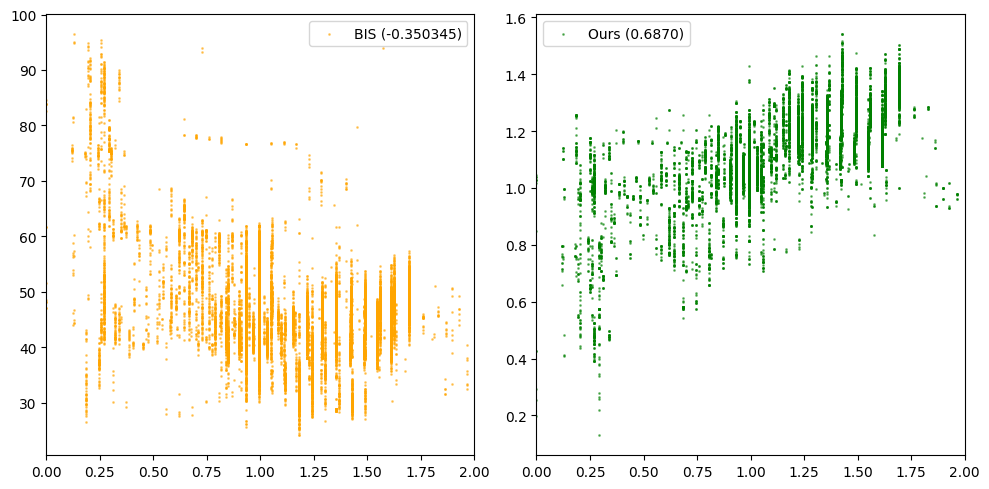

Total MAE=0.2210, CaseID 10, MAE=0.2021


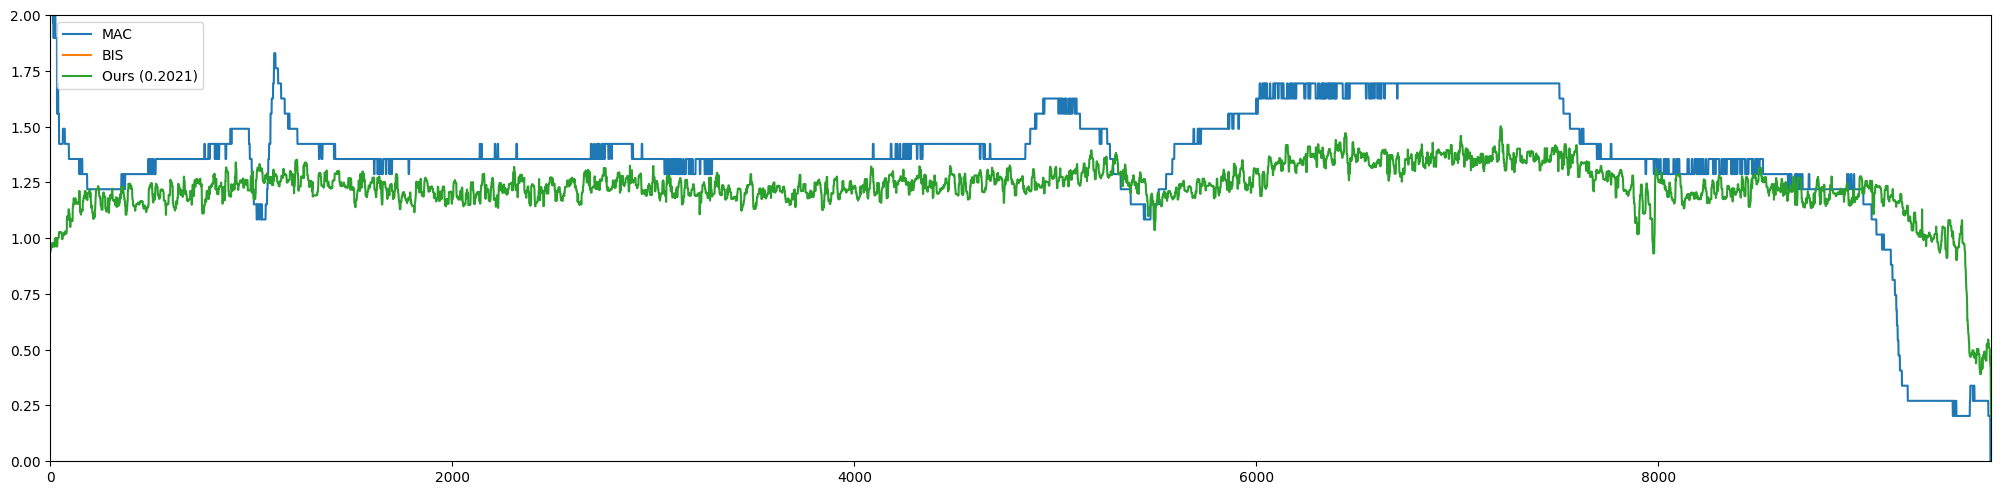

Total MAE=0.2210, CaseID 43, MAE=0.3405


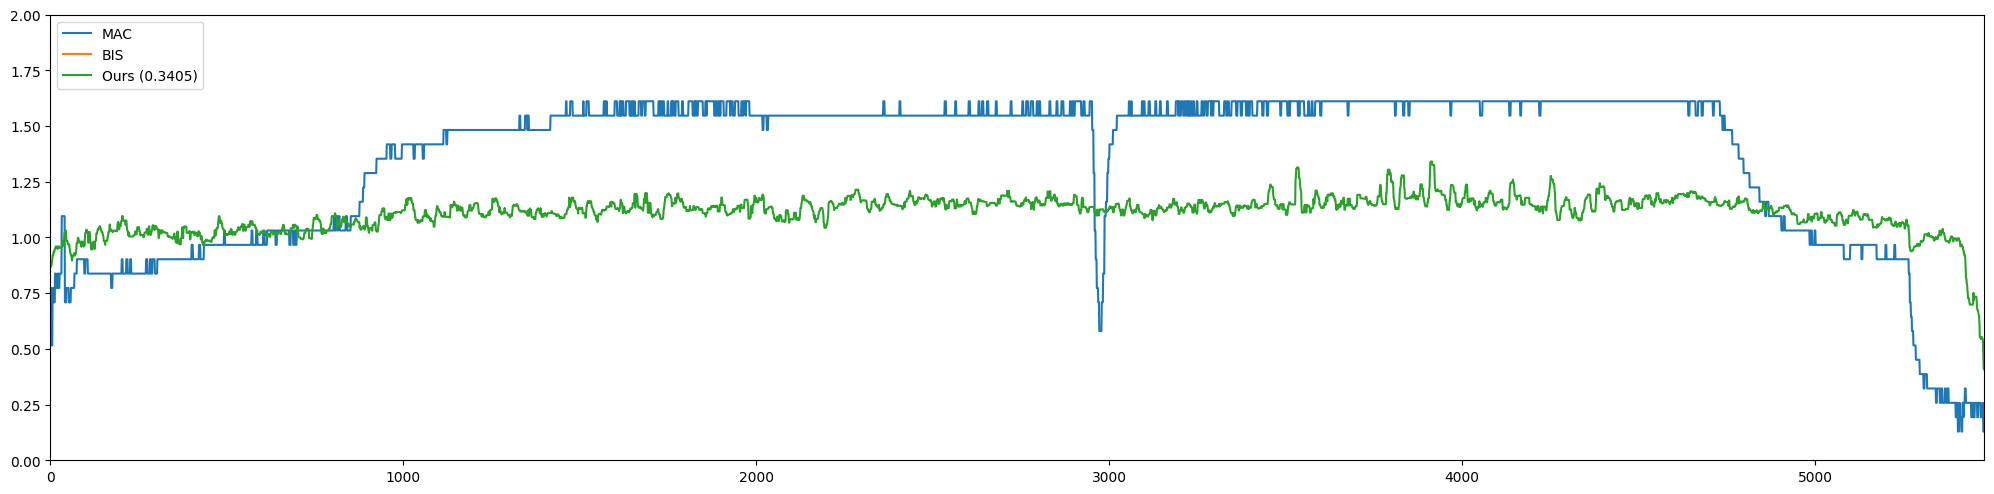

Total MAE=0.2210, CaseID 65, MAE=0.1722


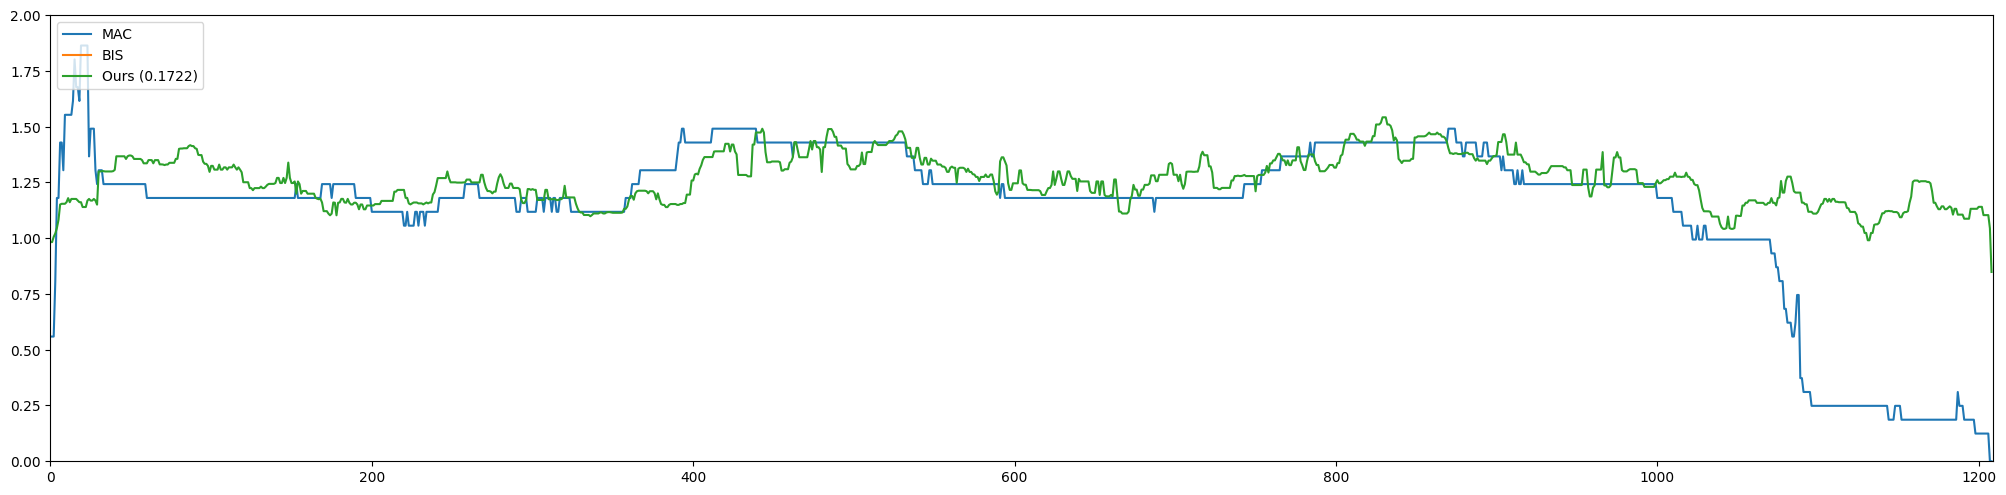

Total MAE=0.2210, CaseID 80, MAE=0.3392


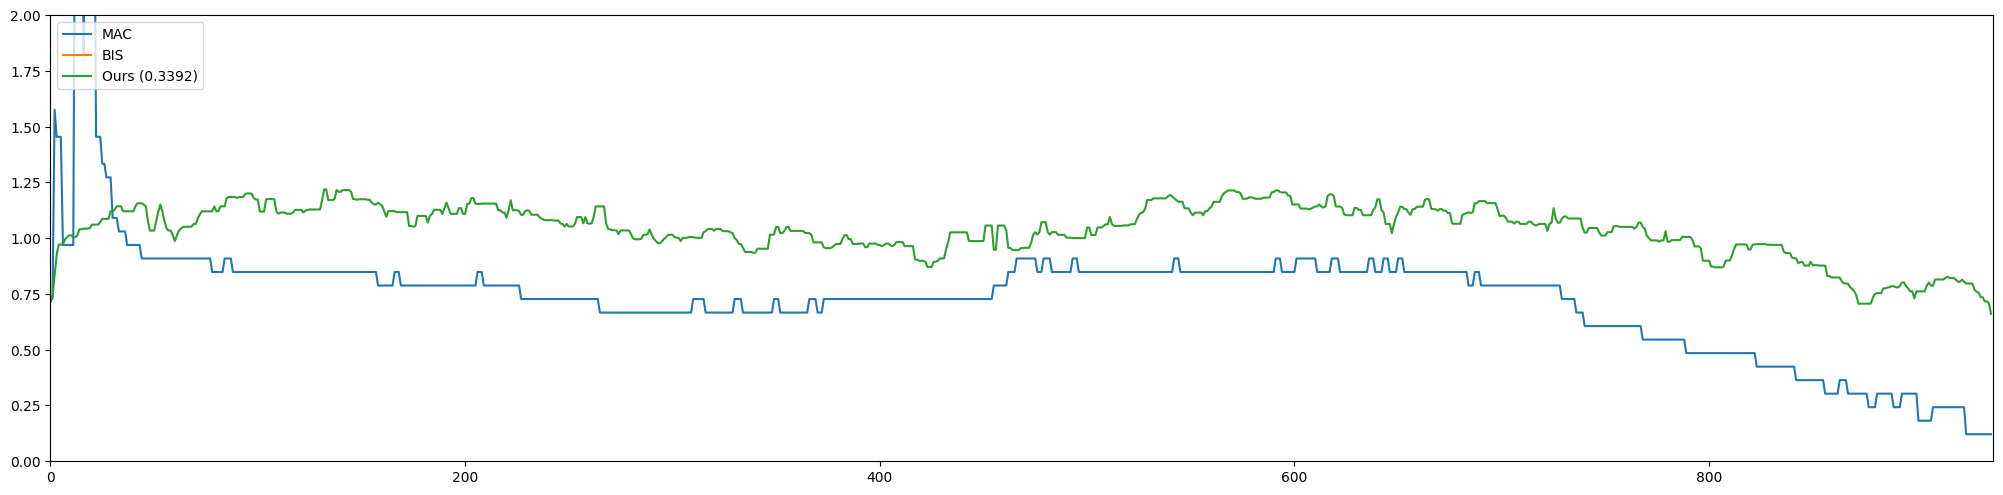

Total MAE=0.2210, CaseID 91, MAE=0.1314


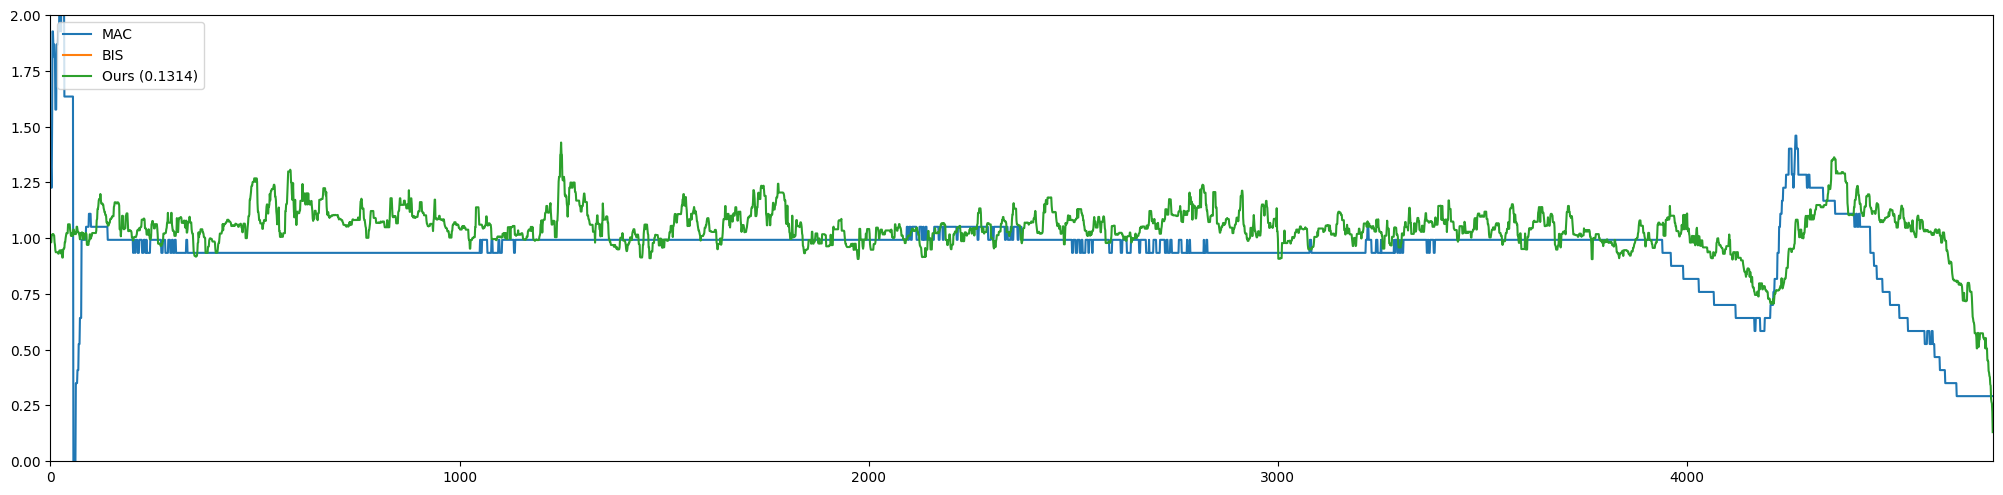

Total MAE=0.2210, CaseID 100, MAE=0.1334


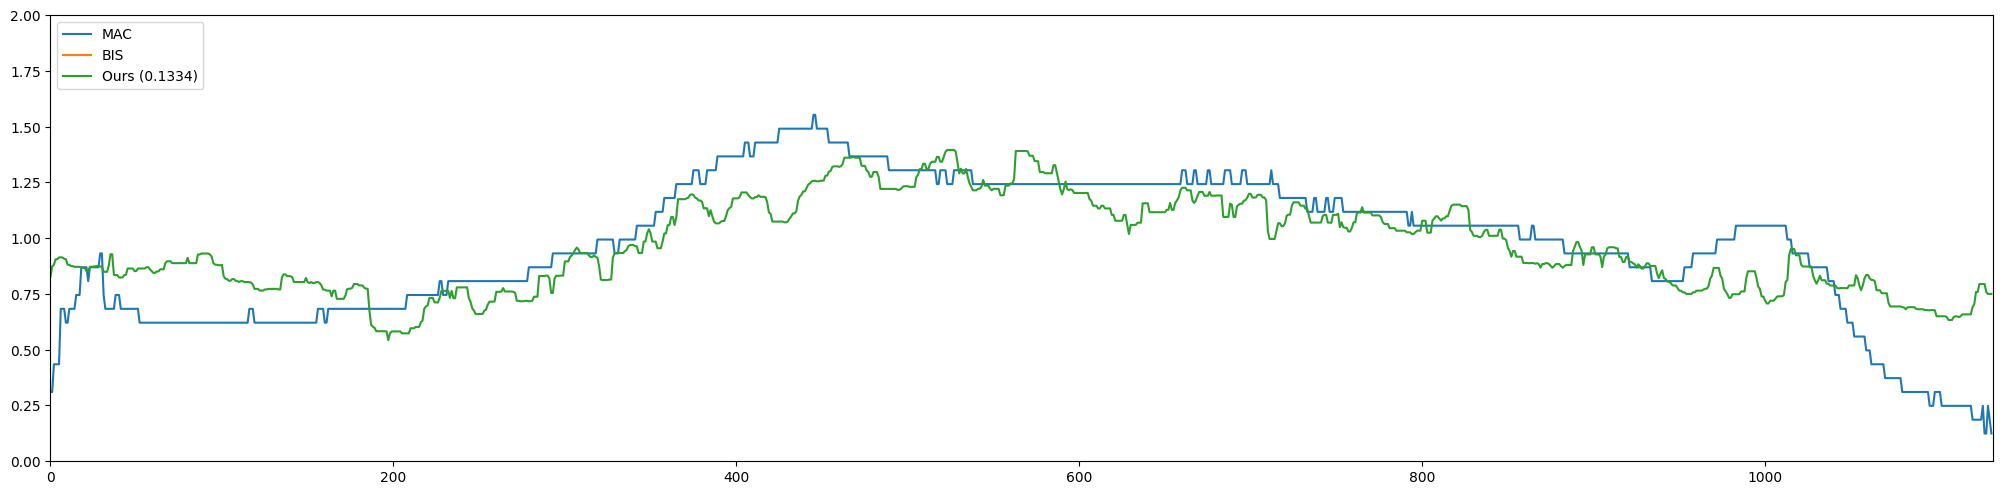

In [35]:
# scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, b_test, s=1, alpha=0.5, c='orange', label='BIS ({:4f})'.format(bis_corr))
plt.xlim([0, 2])
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test, s=1, alpha=0.5, c='green', label='Ours ({:.4f})'.format(our_corr))
plt.xlim([0, 2])
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# plot for each case
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask]))
    print('Total MAE={:.4f}, CaseID {}, MAE={:.4f}'.format(test_mae, caseid, our_mae))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='MAC')
    plt.plot(t, b_test[case_mask], label='BIS')
    plt.plot(t, pred_test[case_mask], label='Ours ({:.4f})'.format(our_mae))
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.xlim([0, case_len])
    plt.ylim([0, 2])
    plt.show()